# Model Selection and Pipelines

In this lab, we'll explore ways to evaluate the quality of models created through training. We'll also begin setting up a basic pipeline, which Python's `sklearn` library provides functions for. Pipelines can be useful when we want to tune parameters and test different models and model parameters on a dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import the linear models from scikit-learn
from sklearn import linear_model
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline

## Load Data

Here we load some data from the City of Chicago for the number of Divvy rides per day in 2018 vs. the minimum temperature for that day. (You were asked to prepare something similar in the homework, so we skip the preparation steps here and focus simply on the machine learning aspects.)

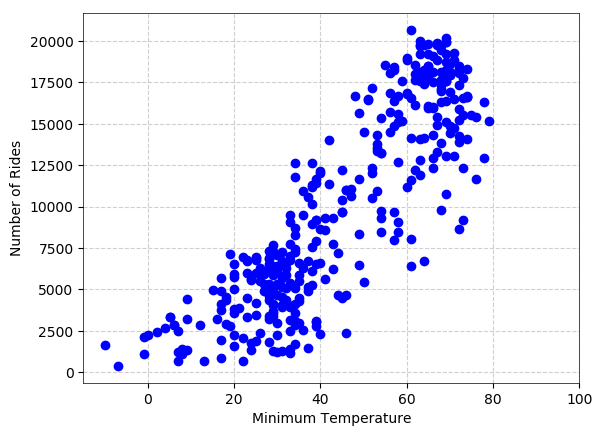

In [2]:
rides_temps = pd.read_csv('../data/rides_temps.csv')

# Plot the original set of points
plt.plot(rides_temps['TMIN'].values, rides_temps['count'].values, '.', color='blue', markersize=12)

# Aesthetics
plt.grid(linestyle='--', alpha=0.6)
plt.xlabel('Minimum Temperature')
plt.ylabel('Number of Rides')
plt.xlim((-15,100))
plt.show()

## Train-Test Split

In [3]:
# Split the Train and Test Sets
rt_train, rt_test = train_test_split(rides_temps, test_size=0.2, random_state=1)

## Regression

First we perform a basic linear regression, with a training and testing split, plotting the result.  The line is the best fit to the test data. We also show the test and training data points separately, to illustrate the two samples.

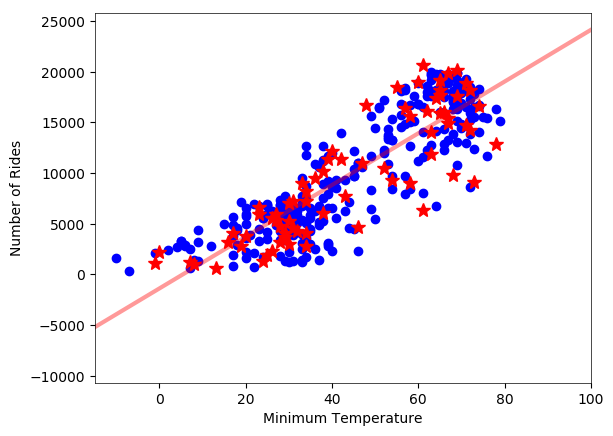

In [4]:
# FEATURES
tmin = rt_train['TMIN'].values.reshape(-1,1)

# NORMALIZE
scaler = StandardScaler()
tmin_norm = scaler.fit_transform(tmin)

# TARGET
rides = rt_train['count'].values

# Fit the linear regression
regr = linear_model.LinearRegression()
regr.fit(tmin_norm, rides)

# Best Line Prediction Based on Training Data
array = np.array([-30.,100.])
y_hat = regr.predict(scaler.transform(array.reshape(-1,1)))

# Plot the original set of training points
plt.plot(tmin, rides, '.', color='blue', markersize=12)

# Plot the test data
plt.plot(rt_test['TMIN'].values, rt_test['count'].values, '*', color='red', markersize=10)

# Predicted line from sklearn is in red
plt.plot([-30, 100], y_hat, color='red', alpha=0.4, linewidth=3)

plt.xlim((-15,100))
plt.xlabel('Minimum Temperature')
plt.ylabel('Number of Rides')
plt.show()

### Evaluation 

We can calculate the mean squared error against the test data.

In [5]:
test_min = rt_test['TMIN'].values.reshape(-1,1)

# Predict on test data.
rides_predicted = regr.predict(scaler.transform(test_min))

# Compare against test targets.
mse_tt = metrics.mean_squared_error(rt_test['count'], rides_predicted)
mse_tt

9439742.614218459

---

## Pipelines and Cross Validation

### Cross-Validation

The above method has a few disadvantages. 

1. The result is highly dependent on how we split the training and test sets: a different 20% held out for the test data could have resulted in a very different result.

2. We are "wasting" 20% of our data, which could have been used to train the model

Cross-validation can help solve this problem.

### Pipelines

The `sklearn` library provides a pipeline mechanism that makes it possible to evaluate a range of models, and perform cross-validation on those models.  Below we will explore the simple creation of a pipeline, and perform a k-fold cross validation on our dataset to perform an evaluation of model accuracy.

### Create a Pipeline

Below, we create a pipeline with default values for polynomial features, alpha, etc. 

Initially, we perform evaluation without varying any of the parameters, but the value of a pipeline is that parameters can be varied, as we will see below when we perform a parameter grid search.

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline

# Create a Pipeline.
# All steps except the last one must call 'fit_transform'
# The last step must call 'fit'
pipeline = Pipeline([
    ('norm', StandardScaler()),
    ('poly', PolynomialFeatures(degree=1,include_bias=False)),
    ('ridge', Ridge(alpha=0.1)),
])

### Perform K-Fold Cross Validation

One thing we can see when we perform the cross-validation is that the MSE can vary significantly depending on the fold. K-Fold cross validation reports the average MSE over all of the folds.

Note that in the example below, we've held out the test set. That is not strictly necessary for this example because we're not doing any parameter exploration (yet). But, when we start exploring the parameter spece in our pipeline, it will be incredibly important that we're not touching our test set during this phase!

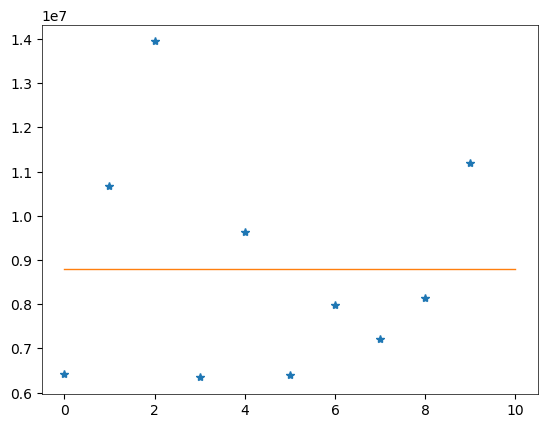

8794096.997823117

In [7]:
# K-Fold Cross Validation
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=23)

# Note: We're only operating on the (smaller) test data here.
# This is what we want to do when tuning hyper-parameters.
# It may also give us reasonable error across our dataset.

cv_results = cross_val_score(pipeline,
                             tmin,
                             rides,
                             cv=kf,
                             scoring='neg_mean_squared_error'
                            )

mse_cv = -cv_results.mean()

plt.plot(-cv_results, '*')
plt.plot(([0,k]), ([mse_cv, mse_cv]))
plt.show()
mse_cv

### Hyper-Parameter Tuning: Grid Search

Grid search can allow for hyper-parameter tuning, with cross validation, such as a the k-fold cross validation that we just performed.  The search performs the evaluation above, automating the search through the set of all possible parameters dedined in the grid.

The resulting model is returned as a result, and a model can be generated from the training data by calling `fit` on the results of the search.

In [8]:
from sklearn.model_selection import GridSearchCV

alpha_range = np.arange(0,1,0.1)
params = {
          'ridge__alpha': alpha_range,
          'poly__degree': (1,2,3)
         }

grid_model = GridSearchCV(estimator=pipeline, 
                          param_grid=params, 
                          cv=k,
                          return_train_score=True,
                          scoring='neg_mean_squared_error',
                          iid=True)

# Use the model that Grid Search determined was the best.
grid_model_result = grid_model.fit(tmin,rides)

We can then plot the test and training data, as well as the predicted model.

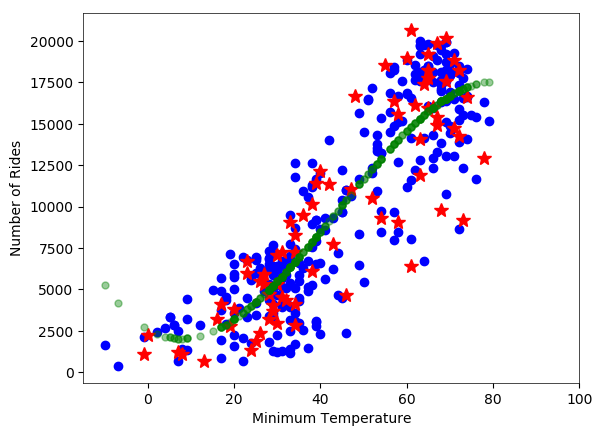

In [9]:
# Plot the original set of points
plt.plot(tmin, rides, '.', color='blue', markersize=12)

# Test data is in red
plt.plot(test_min, rt_test['count'].values, '*', color='red', markersize=10 )

# Predicted model in green
y_hat2 = grid_model.predict(tmin)
plt.plot(tmin, y_hat2,'o', color='green', alpha=0.4, markersize=5)

plt.xlim((-15,100))
plt.xlabel('Minimum Temperature')
plt.ylabel('Number of Rides')
plt.show()

### Evaluation

The evaluation based on MSE shows that the grid search allowed us to find a model that performed better on the test data.

In [10]:
rides_predicted2 = grid_model.predict(test_min)
mse_grid = metrics.mean_squared_error(rt_test['count'], rides_predicted2)
mse_grid

8586065.327067282

In [11]:
print("""
MSE (Train-Test Split):\t{}
MSE (Cross Validation):\t{}
MSE (Grid Search):\t{}
""".format(
        mse_tt,mse_cv,mse_grid))


MSE (Train-Test Split):	9439742.614218459
MSE (Cross Validation):	8794096.997823117
MSE (Grid Search):	8586065.327067282



We can also explore the alpha values and degree expansion that resulted in the best score on the training data. It's also possible to see that the MSE scores for the best models are lower than the scores on the test data that we **explicitly held out** from the cross-validation (note that the "test" below is on the folds during hyper-parameter tuning, not on the actual test data).

In [12]:
cv_results = pd.DataFrame(grid_model.cv_results_)
cv_results.columns
ranked_cv=cv_results.sort_values(by=['rank_test_score'])
ranked_cv[['param_ridge__alpha','param_poly__degree','rank_test_score', 'mean_train_score', 'mean_test_score']]

,param_ridge__alpha,param_poly__degree,rank_test_score,mean_train_score,mean_test_score
29,0.9,3,1,-7.644903e+06,-7.952141e+06
28,0.8,3,2,-7.644503e+06,-7.952269e+06
27,0.7,3,3,-7.644147e+06,-7.952451e+06
26,0.6,3,4,-7.643838e+06,-7.952685e+06
25,0.5,3,5,-7.643575e+06,-7.952974e+06
24,0.4,3,6,-7.643358e+06,-7.953316e+06
23,0.3,3,7,-7.643188e+06,-7.953714e+06
22,0.2,3,8,-7.643067e+06,-7.954167e+06
21,0.1,3,9,-7.642993e+06,-7.954676e+06
20,0,3,10,-7.642969e+06,-7.955242e+06
